# Setup
Import library, set seed, check GPU

In [1]:
# Dataset: Custom dataset with 39 classes (OBJ001 - OBJ439)
# Images: 224x224 RGB
# Models: MLP, Basic CNN, Deeper CNN, Pretrained ResNet18

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import zipfile
import re
import shutil
from PIL import Image
from collections import defaultdict
import warnings

# Suppress PIL warnings
warnings.filterwarnings('ignore', category=Image.DecompressionBombWarning)

# 1.2 Reproducibility

SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# 1.3 Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# 1.4 HEIC Support Installation

def install_heic_support():
    """Install pillow-heif for HEIC/HEIF format support."""
    try:
        import pillow_heif
        pillow_heif.register_heif_opener()
        print("HEIC support available")
    except ImportError:
        print("Installing pillow-heif for HEIC support...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'pillow-heif', '-q'])
        import pillow_heif
        pillow_heif.register_heif_opener()
        print("HEIC support installed")

install_heic_support()

# UPDATE THIS PATH to your uploaded zip file
ZIP_FILE_PATH = '/content/raw_1_train.zip'

# Directories
EXTRACT_DIR = '/content/dataset_raw'
PROCESSED_DIR = '/content/dataset_processed'
CHECKPOINT_DIR = '/content/checkpoints'

# Image settings
TARGET_SIZE = (224, 224)
SUPPORTED_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.heic', '.heif', '.bmp', '.webp', '.tiff', '.tif'}

# Training settings
BATCH_SIZE = 32  # Smaller for 224x224 images
NUM_WORKERS = 2

# Create checkpoint directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("\n" + "=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"Zip file path:    {ZIP_FILE_PATH}")
print(f"Target size:      {TARGET_SIZE}")
print(f"Batch size:       {BATCH_SIZE}")
print(f"Checkpoint dir:   {CHECKPOINT_DIR}")
print(f"Device:           {device}")


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB
Installing pillow-heif for HEIC support...
HEIC support installed

CONFIGURATION
Zip file path:    /content/raw_1_train.zip
Target size:      (224, 224)
Batch size:       32
Checkpoint dir:   /content/checkpoints
Device:           cuda


# Data Pipeline

## Extract and Preprocess Dataset

In [2]:
def extract_and_preprocess_dataset(
    zip_path,
    extract_dir,
    processed_dir,
    target_size=TARGET_SIZE
):
    """
    Extract zip file and preprocess all images:
    - Convert all formats to RGB JPG
    - Resize to target size
    - Organize into class folders

    Args:
        zip_path: Path to uploaded zip file
        extract_dir: Directory to extract raw files
        processed_dir: Directory for processed images
        target_size: Target image size (width, height)

    Returns:
        dict: Statistics about the processing
    """
    stats = {
        'total_found': 0,
        'total_processed': 0,
        'skipped_errors': 0,
        'classes': defaultdict(int),
        'format_counts': defaultdict(int),
        'errors': []
    }

    # Clean up previous runs
    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    if os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    os.makedirs(extract_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)

    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete")

    folder_pattern = re.compile(r'images_OBJ(\d{3})', re.IGNORECASE)

    class_folders = []
    for root, dirs, files in os.walk(extract_dir):
        for dir_name in dirs:
            match = folder_pattern.match(dir_name)
            if match:
                class_id = f"OBJ{match.group(1)}"
                full_path = os.path.join(root, dir_name)
                class_folders.append((class_id, full_path))

    print(f"Found {len(class_folders)} class folders")

    if len(class_folders) == 0:
        print("WARNING: No class folders found!")
        print("Expected folder names like: images_OBJ001, images_OBJ002, ...")
        print("\nDirectories found in extract:")
        for root, dirs, files in os.walk(extract_dir):
            for d in dirs[:10]:  # Show first 10
                print(f"  {d}")
        return stats

    print("\nProcessing images...")

    for class_id, folder_path in sorted(class_folders):
        # Create output folder for this class
        class_output_dir = os.path.join(processed_dir, class_id)
        os.makedirs(class_output_dir, exist_ok=True)

        image_count = 0

        for filename in os.listdir(folder_path):
            file_ext = os.path.splitext(filename)[1].lower()

            if file_ext not in SUPPORTED_EXTENSIONS:
                continue

            stats['total_found'] += 1
            stats['format_counts'][file_ext] += 1

            input_path = os.path.join(folder_path, filename)
            output_filename = f"{class_id}_{image_count:04d}.jpg"
            output_path = os.path.join(class_output_dir, output_filename)

            try:
                # Open image
                with Image.open(input_path) as img:
                    # Convert to RGB (handles RGBA, grayscale, palette, etc.)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Resize to target size
                    if img.size != target_size:
                        img = img.resize(target_size, Image.LANCZOS)

                    # Save as JPG
                    img.save(output_path, 'JPEG', quality=95)

                stats['total_processed'] += 1
                stats['classes'][class_id] += 1
                image_count += 1

            except Exception as e:
                stats['skipped_errors'] += 1
                stats['errors'].append(f"{input_path}: {str(e)}")

        print(f"  {class_id}: {image_count} images")

    print("\n✓ Preprocessing complete")
    return stats



def print_preprocessing_stats(stats):
    """Print summary of preprocessing."""
    print("\n" + "=" * 60)
    print("PREPROCESSING SUMMARY")
    print("=" * 60)

    print(f"\nTotal images found:     {stats['total_found']}")
    print(f"Successfully processed: {stats['total_processed']}")
    print(f"Skipped (errors):       {stats['skipped_errors']}")
    print(f"Number of classes:      {len(stats['classes'])}")

    # Format distribution
    print("\n" + "-" * 60)
    print("Original Format Distribution")
    print("-" * 60)
    for fmt, count in sorted(stats['format_counts'].items()):
        print(f"  {fmt:8s}: {count:5d}")

    # Class distribution
    print("\n" + "-" * 60)
    print("Class Distribution")
    print("-" * 60)

    counts = list(stats['classes'].values())
    for class_id, count in sorted(stats['classes'].items()):
        print(f"  {class_id}: {count:4d} images")

    # Imbalance check
    if counts:
        min_count = min(counts)
        max_count = max(counts)
        avg_count = sum(counts) / len(counts)

        print("\n" + "-" * 60)
        print("Distribution Statistics")
        print("-" * 60)
        print(f"  Min images per class: {min_count}")
        print(f"  Max images per class: {max_count}")
        print(f"  Avg images per class: {avg_count:.1f}")

        if max_count > 2 * min_count:
            print("\n WARNING: Significant class imbalance detected!")
            print("  Consider: weighted loss, oversampling, or data augmentation")

    # Errors
    if stats['errors']:
        print("\n" + "-" * 60)
        print(f"Errors ({len(stats['errors'])} total, showing first 5)")
        print("-" * 60)
        for err in stats['errors'][:5]:
            print(f"  {err}")


In [3]:
# 2.3 Run Preprocessing
# Check if zip file exists
if os.path.exists(ZIP_FILE_PATH):
    stats = extract_and_preprocess_dataset(
        ZIP_FILE_PATH,
        EXTRACT_DIR,
        PROCESSED_DIR,
        TARGET_SIZE
    )
    print_preprocessing_stats(stats)
else:
    print(f"Zip file not found: {ZIP_FILE_PATH}")

Extracting /content/raw_1_train.zip...
Extraction complete
Found 39 class folders

Processing images...
  OBJ001: 100 images
  OBJ002: 100 images
  OBJ003: 100 images
  OBJ004: 100 images
  OBJ005: 100 images
  OBJ006: 100 images
  OBJ007: 100 images
  OBJ008: 100 images
  OBJ009: 100 images
  OBJ010: 100 images
  OBJ011: 108 images
  OBJ012: 110 images
  OBJ016: 99 images
  OBJ018: 120 images
  OBJ019: 100 images
  OBJ021: 100 images
  OBJ022: 99 images
  OBJ027: 100 images
  OBJ028: 100 images
  OBJ029: 100 images
  OBJ031: 100 images
  OBJ061: 100 images
  OBJ069: 100 images
  OBJ090: 100 images
  OBJ095: 101 images
  OBJ107: 144 images
  OBJ108: 100 images
  OBJ111: 100 images
  OBJ159: 136 images
  OBJ208: 100 images
  OBJ229: 126 images
  OBJ230: 140 images
  OBJ300: 100 images
  OBJ311: 124 images
  OBJ405: 100 images
  OBJ786: 100 images
  OBJ787: 100 images
  OBJ788: 100 images
  OBJ789: 100 images

✓ Preprocessing complete

PREPROCESSING SUMMARY

Total images found:     4107


## DataLoaders

In [4]:
class CustomImageDataset(Dataset):
    """
    Custom dataset for processed images.

    Folder structure expected:
        processed_dir/
            OBJ001/
                OBJ001_0000.jpg
                OBJ001_0001.jpg
                ...
            OBJ002/
                OBJ002_0000.jpg
                ...

    Labels are derived from folder names (OBJ001 -> class index 0, OBJ002 -> 1, etc.)
    """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Directory with class subfolders
            transform: Optional transform to apply
        """
        self.root_dir = root_dir
        self.transform = transform

        # Build class mapping from folder names
        # Sorted to ensure consistent ordering
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

        # Build sample list: (image_path, class_idx)
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for filename in sorted(os.listdir(class_dir)):
                if filename.lower().endswith(('.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, filename)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', TARGET_SIZE, (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, class_idx

    def get_class_name(self, idx):
        """Get class name from index."""
        return self.idx_to_class[idx]


# 3.2 Data Transforms

# Using ImageNet statistics (works well with pretrained models)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


def create_dataloaders(
    processed_dir,
    train_ratio=0.70,
    val_ratio=0.15,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED
):
    """
    Create train/val/test data loaders with 70/15/15 split.

    Args:
        processed_dir: Directory with processed class folders
        train_ratio: Fraction for training (default 0.70)
        val_ratio: Fraction for validation (default 0.15)
        batch_size: Batch size for loaders
        num_workers: Number of data loading workers
        seed: Random seed for reproducibility

    Returns:
        train_loader, val_loader, test_loader, class_names, num_classes
    """
    # Create dataset instances
    # Training set uses augmentation
    full_dataset_train = CustomImageDataset(processed_dir, transform=train_transform)
    # Val/Test sets use no augmentation
    full_dataset_eval = CustomImageDataset(processed_dir, transform=test_transform)

    class_names = full_dataset_train.classes
    num_classes = len(class_names)

    # Create random split indices
    np.random.seed(seed)
    num_samples = len(full_dataset_train)
    indices = np.random.permutation(num_samples)

    train_end = int(train_ratio * num_samples)
    val_end = int((train_ratio + val_ratio) * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create subsets
    train_dataset = Subset(full_dataset_train, train_indices)
    val_dataset = Subset(full_dataset_eval, val_indices)
    test_dataset = Subset(full_dataset_eval, test_indices)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader, class_names, num_classes

def print_class_mapping(class_names):
    """Print the class name to index mapping."""
    print("\n" + "=" * 60)
    print("CLASS LABEL MAPPING")
    print("=" * 60)
    print(f"{'Index':<8} {'Class Name':<15}")
    print("-" * 60)
    for idx, name in enumerate(class_names):
        print(f"{idx:<8} {name:<15}")
    print("-" * 60)
    print(f"Total classes: {len(class_names)}")


def visualize_samples(loader, class_names, num_images=8):
    """Visualize a batch of images with their labels."""
    images, labels = next(iter(loader))

    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    images_denorm = images[:num_images] * std + mean
    images_denorm = torch.clamp(images_denorm, 0, 1)

    # Plot
    fig, axes = plt.subplots(1, num_images, figsize=(16, 3))
    for i in range(min(num_images, len(images))):
        axes[i].imshow(images_denorm[i].permute(1, 2, 0).numpy())
        axes[i].set_title(f"{class_names[labels[i]]}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle("Sample Images with Labels (Folder Name = Label)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

def verify_split_distribution(train_dataset, val_dataset, test_dataset, class_names):
    """Verify class distribution across train/val/test splits."""

    def count_classes(dataset):
        counts = defaultdict(int)
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            counts[label] += 1
        return counts

    print("\n" + "=" * 60)
    print("CLASS DISTRIBUTION ACROSS SPLITS")
    print("=" * 60)

    train_counts = count_classes(train_dataset)
    val_counts = count_classes(val_dataset)
    test_counts = count_classes(test_dataset)

    print(f"{'Class':<10} {'Train':>8} {'Val':>8} {'Test':>8} {'Total':>8}")
    print("-" * 60)

    for idx, name in enumerate(class_names):
        tr = train_counts.get(idx, 0)
        va = val_counts.get(idx, 0)
        te = test_counts.get(idx, 0)
        total = tr + va + te
        print(f"{name:<10} {tr:>8} {va:>8} {te:>8} {total:>8}")

    print("-" * 60)
    print(f"{'TOTAL':<10} {len(train_dataset):>8} {len(val_dataset):>8} {len(test_dataset):>8} {len(train_dataset)+len(val_dataset)+len(test_dataset):>8}")



Data loaders created
  Training samples:   2,874
  Validation samples: 616
  Test samples:       617
  Number of classes:  39
  Batch size:         32
  Train batches:      90

CLASS LABEL MAPPING
Index    Class Name     
------------------------------------------------------------
0        OBJ001         
1        OBJ002         
2        OBJ003         
3        OBJ004         
4        OBJ005         
5        OBJ006         
6        OBJ007         
7        OBJ008         
8        OBJ009         
9        OBJ010         
10       OBJ011         
11       OBJ012         
12       OBJ016         
13       OBJ018         
14       OBJ019         
15       OBJ021         
16       OBJ022         
17       OBJ027         
18       OBJ028         
19       OBJ029         
20       OBJ031         
21       OBJ061         
22       OBJ069         
23       OBJ090         
24       OBJ095         
25       OBJ107         
26       OBJ108         
27       OBJ111         
28       OBJ159 

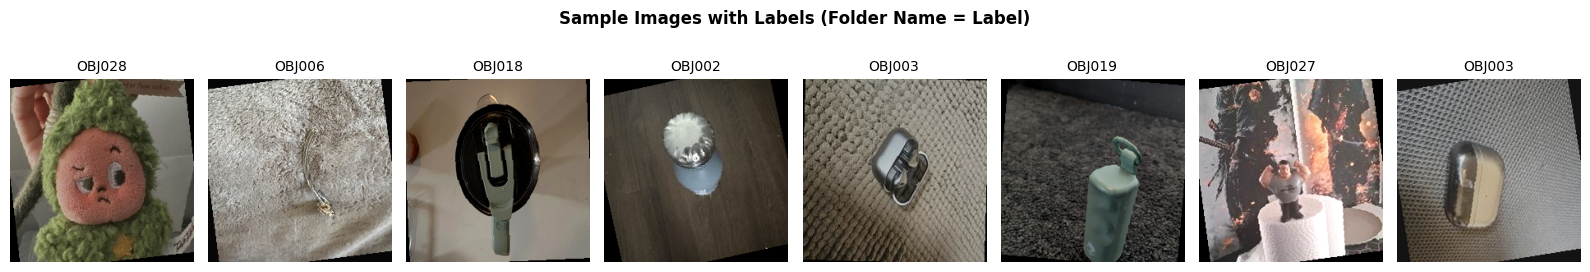

In [5]:
if os.path.exists(PROCESSED_DIR) and len(os.listdir(PROCESSED_DIR)) > 0:
    # Create loaders
    train_loader, val_loader, test_loader, class_names, num_classes = create_dataloaders(
        PROCESSED_DIR,
        train_ratio=0.70,
        val_ratio=0.15,
        batch_size=BATCH_SIZE
    )

    print(f"\nData loaders created")
    print(f"  Training samples:   {len(train_loader.dataset):,}")
    print(f"  Validation samples: {len(val_loader.dataset):,}")
    print(f"  Test samples:       {len(test_loader.dataset):,}")
    print(f"  Number of classes:  {num_classes}")
    print(f"  Batch size:         {BATCH_SIZE}")
    print(f"  Train batches:      {len(train_loader)}")

    # Print class mapping
    print_class_mapping(class_names)

    # Visualize samples
    print("\n" + "=" * 60)
    print("SAMPLE VISUALIZATION")
    print("=" * 60)
    visualize_samples(train_loader, class_names, num_images=8)

else:
    print("Processed directory not found or empty.")

# Model Definitions

## Model 1: Simple MLP (Baseline)

In [6]:
class SimpleMLP(nn.Module):
    """
    Baseline: Fully connected network with adaptive pooling.
    No spatial reasoning - expected to perform poorly.

    Note: 224x224x3 = 150,528 inputs is too large for direct FC,
    so we use adaptive pooling to reduce spatial dimensions first.
    """
    def __init__(self, num_classes):
        super(SimpleMLP, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((32, 32))  # Reduce to 32x32
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        x = self.layers(x)
        return x

## Model 2: Basic CNN (2 conv blocks)

In [7]:
class BasicCNN(nn.Module):
    """
    Minimal CNN: 3 convolutional blocks + classifier.
    Demonstrates basic spatial feature learning.
    """
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2: 112 -> 56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3: 56 -> 28
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Adaptive pooling for fixed output size
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Model 3: Deeper CNN (VGG-style, 4 conv blocks with BatchNorm)

In [8]:
class DeeperCNN(nn.Module):
    """
    VGG-style architecture: 3 blocks with BatchNorm.
    More capacity for complex patterns.
    """
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2: 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3: 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Adaptive pooling for fixed output size
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Model 4: Pretrained ResNet18 (Modified for CIFAR-10)

In [9]:
class PretrainedResNet18(nn.Module):
    """
    ResNet18 pretrained on ImageNet.
    224x224 is the native input size for ResNet.
    Only the final FC layer is replaced for our number of classes.
    """
    def __init__(self, num_classes, pretrained=True):
        super(PretrainedResNet18, self).__init__()

        if pretrained:
            self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.model = resnet18(weights=None)

        # Replace final FC layer for our number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

    def freeze_backbone(self):
        """Freeze all layers except final FC."""
        for name, param in self.model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

    def unfreeze_backbone(self):
        """Unfreeze all layers for fine-tuning."""
        for param in self.model.parameters():
            param.requires_grad = True

## Count Parameter and validation

In [10]:
def count_parameters(model):
    """Count total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Check if num_classes is defined (from Component 3)
if 'num_classes' not in dir():
    print("num_classes not defined. Using placeholder value of 39.")
    num_classes = 39

# Create test instances
models_config = {
    'SimpleMLP': SimpleMLP(num_classes=num_classes),
    'BasicCNN': BasicCNN(num_classes=num_classes),
    'DeeperCNN': DeeperCNN(num_classes=num_classes),
    'PretrainedResNet18': PretrainedResNet18(num_classes=num_classes, pretrained=True)
}

# Test forward pass with dummy input (224x224)
dummy_input = torch.randn(2, 3, 224, 224)

print(f"\nValidating models for {num_classes} classes, input size 224x224\n")
print(f"{'Model':<20} {'Total Params':>15} {'Output Shape':>15} {'Status':>10}")
print("-" * 65)

for name, model in models_config.items():
    model.eval()
    total_params, trainable_params = count_parameters(model)

    try:
        with torch.no_grad():
            output = model(dummy_input)
        output_shape = tuple(output.shape)
        status = "OK"
    except Exception as e:
        output_shape = "Error"
        status = f"{e}"

    print(f"{name:<20} {total_params:>15,} {str(output_shape):>15} {status:>10}")

print("-" * 65)
print("\n All models validated")

# Clean up test instances
del models_config, dummy_input

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 240MB/s]



Validating models for 39 classes, input size 224x224

Model                   Total Params    Output Shape     Status
-----------------------------------------------------------------
SimpleMLP                  1,714,727         (2, 39)         OK
BasicCNN                     869,415         (2, 39)         OK
DeeperCNN                  7,590,247         (2, 39)         OK
PretrainedResNet18        11,196,519         (2, 39)         OK
-----------------------------------------------------------------

 All models validated


# Training Function

In [11]:
# 5.1 General Training Function
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=20,
    device=device,
    model_name='model',
    save_checkpoints=True
):
    """
    Train a model and track metrics.

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        num_epochs: Number of epochs
        device: Device to train on
        model_name: Name for checkpoint files
        save_checkpoints: Whether to save checkpoints

    Returns:
        dict: Training history
    """
    model = model.to(device)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'epoch_times': [],
        'total_train_time': 0,
        'best_val_accuracy': 0,
        'best_epoch': 0
    }

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

       # Training Phase
        model.train()
        running_loss = 0.0
        num_batches = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        avg_train_loss = running_loss / num_batches

        # Validation Phase

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100.0 * correct / total

        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Track epoch time
        epoch_time = time.time() - epoch_start_time

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['epoch_times'].append(epoch_time)

        # Track best model
        if val_accuracy > history['best_val_accuracy']:
            history['best_val_accuracy'] = val_accuracy
            history['best_epoch'] = epoch + 1

            if save_checkpoints:
                checkpoint_path = os.path.join(CHECKPOINT_DIR, f'{model_name}_best.pth')
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_accuracy': val_accuracy,
                }, checkpoint_path)

        # Print progress
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"LR: {current_lr:.6f} | "
              f"Time: {epoch_time:.1f}s")

    # Total training time
    history['total_train_time'] = time.time() - total_start_time

    print(f"\nTraining complete in {history['total_train_time']:.1f}s")
    print(f"Best Val Accuracy: {history['best_val_accuracy']:.2f}% (Epoch {history['best_epoch']})")

    return history

# 5.2 Two-Phase Training for Pretrained ResNet18

def train_resnet_two_phase(
    model,
    train_loader,
    val_loader,
    criterion,
    device=device,
    model_name='ResNet18',
    frozen_epochs=5,
    unfrozen_epochs=15,
    frozen_lr=1e-3,
    unfrozen_lr=1e-4
):
    """
    Two-phase training for pretrained ResNet:
    Phase 1: Freeze backbone, train classifier only (fast convergence)
    Phase 2: Unfreeze all, fine-tune with lower LR (refine features)

    Returns:
        dict: Combined training history
    """
    model = model.to(device)

    # Phase 1: Frozen Backbone

    print("=" * 60)
    print("Phase 1: Training with FROZEN backbone")

    model.freeze_backbone()
    _, trainable_phase1 = count_parameters(model)
    print(f"Trainable parameters: {trainable_phase1:,} (classifier only)\n")

    optimizer_phase1 = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=frozen_lr
    )

    history_phase1 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_phase1,
        scheduler=None,
        num_epochs=frozen_epochs,
        device=device,
        model_name=f'{model_name}_phase1',
        save_checkpoints=True
    )

    # Phase 2: Unfrozen (Fine-tuning)

    print("\n" + "=" * 60)
    print("Phase 2: Fine-tuning ENTIRE network")

    model.unfreeze_backbone()
    _, trainable_phase2 = count_parameters(model)
    print(f"Trainable parameters: {trainable_phase2:,} (all layers)\n")

    optimizer_phase2 = optim.Adam(model.parameters(), lr=unfrozen_lr)
    scheduler_phase2 = optim.lr_scheduler.StepLR(optimizer_phase2, step_size=5, gamma=0.5)

    history_phase2 = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_phase2,
        scheduler=scheduler_phase2,
        num_epochs=unfrozen_epochs,
        device=device,
        model_name=f'{model_name}_phase2',
        save_checkpoints=True
    )

    combined_history = {
        'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
        'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
        'val_accuracy': history_phase1['val_accuracy'] + history_phase2['val_accuracy'],
        'epoch_times': history_phase1['epoch_times'] + history_phase2['epoch_times'],
        'total_train_time': history_phase1['total_train_time'] + history_phase2['total_train_time'],
        'best_val_accuracy': max(history_phase1['best_val_accuracy'], history_phase2['best_val_accuracy']),
        'best_epoch': (
            history_phase2['best_epoch'] + frozen_epochs
            if history_phase2['best_val_accuracy'] >= history_phase1['best_val_accuracy']
            else history_phase1['best_epoch']
        ),
        'phase1_epochs': frozen_epochs,
        'phase2_epochs': unfrozen_epochs
    }

    print("\n" + "=" * 60)
    print("Two-Phase Training Complete")
    print("=" * 60)
    print(f"Total training time: {combined_history['total_train_time']:.1f}s")
    print(f"Best Val Accuracy: {combined_history['best_val_accuracy']:.2f}%")

    return combined_history

def load_checkpoint(model, checkpoint_path, device=device):
    """Load model from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f" Loaded checkpoint: {checkpoint_path}")
    print(f" Epoch: {checkpoint['epoch']}, Val Accuracy: {checkpoint['val_accuracy']:.2f}%")
    return model


# Evaluation Function

In [12]:
def evaluate_model(model, test_loader, class_names, device=device, num_warmup_batches=3):
    """
    Evaluate model on test set.

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        class_names: List of class names
        device: Device to evaluate on
        num_warmup_batches: Number of batches for GPU warmup before timing

    Returns:
        dict: Evaluation results
    """
    model = model.to(device)
    model.eval()

    num_classes = len(class_names)

    # Tracking variables
    all_predictions = []
    all_labels = []

    # GPU Warmup (for accurate timing)
    print("Warming up GPU...")
    with torch.no_grad():
        warmup_count = 0
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
            warmup_count += 1
            if warmup_count >= num_warmup_batches:
                break

    if device.type == 'cuda':
        torch.cuda.synchronize()

    # Inference with Timing

    print("Running evaluation...")
    total_images = 0
    inference_start = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            total_images += labels.size(0)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    inference_end = time.time()
    total_inference_time = inference_end - inference_start


    # Calculate Metrics

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Overall accuracy
    correct = (all_predictions == all_labels).sum()
    overall_accuracy = 100.0 * correct / total_images

    # Per-class accuracy
    per_class_correct = {}
    per_class_total = {}
    per_class_accuracy = {}

    for class_idx in range(num_classes):
        mask = (all_labels == class_idx)
        class_total = mask.sum()
        class_correct = ((all_predictions == class_idx) & mask).sum()

        per_class_total[class_idx] = int(class_total)
        per_class_correct[class_idx] = int(class_correct)

        if class_total > 0:
            per_class_accuracy[class_idx] = 100.0 * class_correct / class_total
        else:
            per_class_accuracy[class_idx] = 0.0

    # Inference time per image (milliseconds)
    inference_time_per_image = (total_inference_time / total_images) * 1000

    # Build Results Dictionary

    results = {
        'overall_accuracy': overall_accuracy,
        'per_class_accuracy': per_class_accuracy,
        'per_class_correct': per_class_correct,
        'per_class_total': per_class_total,
        'total_images': total_images,
        'total_inference_time': total_inference_time,
        'inference_time_per_image_ms': inference_time_per_image,
        'predictions': all_predictions,
        'labels': all_labels
    }

    return results
# 6.2 Print Evaluation Results
def print_evaluation_results(results, class_names, model_name="Model"):
    """Pretty print evaluation results."""
    print("\n" + "=" * 60)
    print(f"EVALUATION RESULTS: {model_name}")
    print("=" * 60)

    print(f"\nOverall Test Accuracy: {results['overall_accuracy']:.2f}%")
    print(f"Total Test Images:     {results['total_images']:,}")
    print(f"Total Inference Time:  {results['total_inference_time']:.3f}s")
    print(f"Inference per Image:   {results['inference_time_per_image_ms']:.3f} ms")

    print("\n" + "-" * 60)
    print("Per-Class Accuracy")
    print("-" * 60)
    print(f"{'Class':<12} {'Correct':>10} {'Total':>10} {'Accuracy':>12}")
    print("-" * 60)

    for class_idx, class_name in enumerate(class_names):
        correct = results['per_class_correct'][class_idx]
        total = results['per_class_total'][class_idx]
        acc = results['per_class_accuracy'][class_idx]
        print(f"{class_name:<12} {correct:>10} {total:>10} {acc:>11.2f}%")

    print("-" * 60)

    # Best and worst classes
    best_idx = max(results['per_class_accuracy'], key=results['per_class_accuracy'].get)
    worst_idx = min(results['per_class_accuracy'], key=results['per_class_accuracy'].get)

    print(f"\nBest Class:  {class_names[best_idx]} ({results['per_class_accuracy'][best_idx]:.2f}%)")
    print(f"Worst Class: {class_names[worst_idx]} ({results['per_class_accuracy'][worst_idx]:.2f}%)")

# 6.3 Confusion Matrix
def plot_confusion_matrix(results, class_names, model_name="Model", figsize=(12, 10)):
    """Plot normalized confusion matrix."""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(results['labels'], results['predictions'])

    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Labels
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        title=f'Confusion Matrix: {model_name}\n(Accuracy: {results["overall_accuracy"]:.2f}%)',
        ylabel='True Label',
        xlabel='Predicted Label'
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)

    # Add diagonal values only (for readability with many classes)
    for i in range(len(class_names)):
        value = cm_normalized[i, i]
        ax.text(i, i, f'{value:.2f}',
                ha="center", va="center",
                color="white" if value > 0.5 else "black",
                fontsize=7)

    fig.tight_layout()
    plt.show()

    return cm

# 6.4 Model Comparison Table
def create_comparison_table(all_results, all_histories, model_names):
    """Create a comparison table for all models."""
    print("\n" + "=" * 85)
    print("MODEL COMPARISON SUMMARY")
    print("=" * 85)
    print(f"{'Model':<20} {'Test Acc':>12} {'Inf. Time (ms)':>16} {'Train Time':>14} {'Params':>15}")
    print("-" * 85)

    for name in model_names:
        if name in all_results:
            r = all_results[name]
            h = all_histories[name]

            acc = r['overall_accuracy']
            inf_time = r['inference_time_per_image_ms']
            train_time = h['total_train_time']
            params = r.get('total_params', 0)

            # Format training time
            if train_time >= 60:
                train_str = f"{train_time/60:.1f} min"
            else:
                train_str = f"{train_time:.1f} s"

            print(f"{name:<20} {acc:>11.2f}% {inf_time:>15.3f} {train_str:>14} {params:>15,}")

    print("=" * 85)

    # Find best model
    best_model = max(all_results.keys(), key=lambda k: all_results[k]['overall_accuracy'])
    print(f"\nBest Model: {best_model} ({all_results[best_model]['overall_accuracy']:.2f}%)")

# Experiments

In [13]:
# Storage for all results
all_results = {}
all_histories = {}

# Loss function (shared across all models)
criterion = nn.CrossEntropyLoss()


## Experiment 1: Simple MLP

In [14]:
# Verify data loaders exist
if 'train_loader' not in dir() or 'num_classes' not in dir():
    print("Data loaders not found.")
else:
    print("=" * 70)
    print("STEP 6: TRAINING ALL MODELS")
    print("=" * 70)
    print(f"Dataset: {num_classes} classes")
    print(f"Training samples: {len(train_loader.dataset):,}")
    print(f"Validation samples: {len(val_loader.dataset):,}")
    print(f"Test samples: {len(test_loader.dataset):,}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Device: {device}")


    model_mlp = SimpleMLP(num_classes=num_classes)
    total_params, _ = count_parameters(model_mlp)
    print(f"Parameters: {total_params:,}\n")

    optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)

    history_mlp = train_model(
        model=model_mlp,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_mlp,
        scheduler=None,
        num_epochs=20,
        device=device,
        model_name='SimpleMLP'
    )

    print("\nEvaluating on test set...")
    results_mlp = evaluate_model(
        model=model_mlp,
        test_loader=test_loader,
        class_names=class_names,
        device=device
    )
    results_mlp['total_params'] = total_params

    print_evaluation_results(results_mlp, class_names, "Simple MLP")

    all_results['SimpleMLP'] = results_mlp
    all_histories['SimpleMLP'] = history_mlp

STEP 6: TRAINING ALL MODELS
Dataset: 39 classes
Training samples: 2,874
Validation samples: 616
Test samples: 617
Batch size: 32
Device: cuda
Parameters: 1,714,727

Epoch [ 1/20] | Train Loss: 2.9340 | Val Loss: 2.4016 | Val Acc: 36.53% | LR: 0.001000 | Time: 6.7s
Epoch [ 2/20] | Train Loss: 2.1993 | Val Loss: 2.0983 | Val Acc: 44.48% | LR: 0.001000 | Time: 6.3s
Epoch [ 3/20] | Train Loss: 1.9520 | Val Loss: 1.8108 | Val Acc: 50.16% | LR: 0.001000 | Time: 6.6s
Epoch [ 4/20] | Train Loss: 1.7148 | Val Loss: 1.6554 | Val Acc: 51.95% | LR: 0.001000 | Time: 6.4s
Epoch [ 5/20] | Train Loss: 1.5506 | Val Loss: 1.6893 | Val Acc: 51.95% | LR: 0.001000 | Time: 6.5s
Epoch [ 6/20] | Train Loss: 1.4859 | Val Loss: 1.5908 | Val Acc: 59.58% | LR: 0.001000 | Time: 6.5s
Epoch [ 7/20] | Train Loss: 1.3558 | Val Loss: 1.5742 | Val Acc: 56.17% | LR: 0.001000 | Time: 6.4s
Epoch [ 8/20] | Train Loss: 1.2673 | Val Loss: 1.5001 | Val Acc: 61.53% | LR: 0.001000 | Time: 6.5s
Epoch [ 9/20] | Train Loss: 1.2393 

## Experiment 2: Basic CNN

In [15]:
if 'train_loader' not in dir() or 'num_classes' not in dir():
    print("Data loaders not found.")
else:
    model_basic_cnn = BasicCNN(num_classes=num_classes)
    total_params, _ = count_parameters(model_basic_cnn)
    print(f"Parameters: {total_params:,}\n")

    optimizer_basic_cnn = optim.Adam(model_basic_cnn.parameters(), lr=1e-3)

    history_basic_cnn = train_model(
        model=model_basic_cnn,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_basic_cnn,
        scheduler=None,
        num_epochs=20,
        device=device,
        model_name='BasicCNN'
    )

    print("\nEvaluating on test set...")
    results_basic_cnn = evaluate_model(
        model=model_basic_cnn,
        test_loader=test_loader,
        class_names=class_names,
        device=device
    )
    results_basic_cnn['total_params'] = total_params

    print_evaluation_results(results_basic_cnn, class_names, "Basic CNN")

    all_results['BasicCNN'] = results_basic_cnn
    all_histories['BasicCNN'] = history_basic_cnn

Parameters: 869,415

Epoch [ 1/20] | Train Loss: 3.2620 | Val Loss: 2.4108 | Val Acc: 36.85% | LR: 0.001000 | Time: 6.8s
Epoch [ 2/20] | Train Loss: 2.2274 | Val Loss: 1.6086 | Val Acc: 58.60% | LR: 0.001000 | Time: 6.7s
Epoch [ 3/20] | Train Loss: 1.6733 | Val Loss: 1.2952 | Val Acc: 67.05% | LR: 0.001000 | Time: 6.5s
Epoch [ 4/20] | Train Loss: 1.3915 | Val Loss: 0.9801 | Val Acc: 74.03% | LR: 0.001000 | Time: 6.6s
Epoch [ 5/20] | Train Loss: 1.2046 | Val Loss: 0.8855 | Val Acc: 76.30% | LR: 0.001000 | Time: 6.7s
Epoch [ 6/20] | Train Loss: 1.0415 | Val Loss: 0.8169 | Val Acc: 79.06% | LR: 0.001000 | Time: 6.5s
Epoch [ 7/20] | Train Loss: 0.9328 | Val Loss: 0.7592 | Val Acc: 80.68% | LR: 0.001000 | Time: 6.7s
Epoch [ 8/20] | Train Loss: 0.8648 | Val Loss: 0.6754 | Val Acc: 80.68% | LR: 0.001000 | Time: 6.6s
Epoch [ 9/20] | Train Loss: 0.7794 | Val Loss: 0.6494 | Val Acc: 82.95% | LR: 0.001000 | Time: 6.7s
Epoch [10/20] | Train Loss: 0.7035 | Val Loss: 0.5656 | Val Acc: 84.58% | LR: 0

## Experiment 3: Deeper CNN

In [16]:
if 'train_loader' not in dir() or 'num_classes' not in dir():
    print("Data loaders not found.")
else:

    model_deeper_cnn = DeeperCNN(num_classes=num_classes)
    total_params, _ = count_parameters(model_deeper_cnn)
    print(f"Parameters: {total_params:,}\n")

    optimizer_deeper_cnn = optim.Adam(model_deeper_cnn.parameters(), lr=1e-3)
    scheduler_deeper_cnn = optim.lr_scheduler.StepLR(
        optimizer_deeper_cnn, step_size=10, gamma=0.1
    )

    history_deeper_cnn = train_model(
        model=model_deeper_cnn,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_deeper_cnn,
        scheduler=scheduler_deeper_cnn,
        num_epochs=30,
        device=device,
        model_name='DeeperCNN'
    )

    print("\nEvaluating on test set...")
    results_deeper_cnn = evaluate_model(
        model=model_deeper_cnn,
        test_loader=test_loader,
        class_names=class_names,
        device=device
    )
    results_deeper_cnn['total_params'] = total_params

    print_evaluation_results(results_deeper_cnn, class_names, "Deeper CNN")

    all_results['DeeperCNN'] = results_deeper_cnn
    all_histories['DeeperCNN'] = history_deeper_cnn


Parameters: 7,590,247

Epoch [ 1/30] | Train Loss: 3.4760 | Val Loss: 2.3193 | Val Acc: 39.45% | LR: 0.001000 | Time: 6.7s
Epoch [ 2/30] | Train Loss: 2.4189 | Val Loss: 2.1460 | Val Acc: 43.34% | LR: 0.001000 | Time: 6.5s
Epoch [ 3/30] | Train Loss: 2.0855 | Val Loss: 1.8400 | Val Acc: 50.65% | LR: 0.001000 | Time: 6.6s
Epoch [ 4/30] | Train Loss: 1.7807 | Val Loss: 1.2186 | Val Acc: 68.83% | LR: 0.001000 | Time: 6.5s
Epoch [ 5/30] | Train Loss: 1.6056 | Val Loss: 1.1594 | Val Acc: 65.10% | LR: 0.001000 | Time: 6.5s
Epoch [ 6/30] | Train Loss: 1.5406 | Val Loss: 1.0913 | Val Acc: 67.05% | LR: 0.001000 | Time: 6.5s
Epoch [ 7/30] | Train Loss: 1.3506 | Val Loss: 0.8630 | Val Acc: 75.16% | LR: 0.001000 | Time: 6.5s
Epoch [ 8/30] | Train Loss: 1.2422 | Val Loss: 0.8205 | Val Acc: 76.62% | LR: 0.001000 | Time: 6.6s
Epoch [ 9/30] | Train Loss: 1.1221 | Val Loss: 0.7101 | Val Acc: 79.87% | LR: 0.001000 | Time: 6.6s
Epoch [10/30] | Train Loss: 1.0500 | Val Loss: 0.8434 | Val Acc: 75.97% | LR:

## Experiment 4: Pretrained ResNet18

In [17]:
if 'train_loader' not in dir() or 'num_classes' not in dir():
    print("Data loaders not found.")
else:
    model_resnet = PretrainedResNet18(num_classes=num_classes, pretrained=True)
    total_params, _ = count_parameters(model_resnet)
    print(f"Total Parameters: {total_params:,}\n")

    history_resnet = train_resnet_two_phase(
        model=model_resnet,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        model_name='ResNet18',
        frozen_epochs=5,
        unfrozen_epochs=15,
        frozen_lr=1e-3,
        unfrozen_lr=1e-4
    )

    print("\nEvaluating on test set...")
    results_resnet = evaluate_model(
        model=model_resnet,
        test_loader=test_loader,
        class_names=class_names,
        device=device
    )
    results_resnet['total_params'] = total_params

    print_evaluation_results(results_resnet, class_names, "Pretrained ResNet18")

    all_results['ResNet18'] = results_resnet
    all_histories['ResNet18'] = history_resnet

Total Parameters: 11,196,519

Phase 1: Training with FROZEN backbone
Trainable parameters: 20,007 (classifier only)

Epoch [ 1/5] | Train Loss: 2.1904 | Val Loss: 0.8803 | Val Acc: 92.86% | LR: 0.001000 | Time: 6.5s
Epoch [ 2/5] | Train Loss: 0.6778 | Val Loss: 0.4157 | Val Acc: 95.45% | LR: 0.001000 | Time: 6.7s
Epoch [ 3/5] | Train Loss: 0.3629 | Val Loss: 0.2702 | Val Acc: 96.92% | LR: 0.001000 | Time: 6.6s
Epoch [ 4/5] | Train Loss: 0.2467 | Val Loss: 0.2121 | Val Acc: 97.08% | LR: 0.001000 | Time: 6.6s
Epoch [ 5/5] | Train Loss: 0.1777 | Val Loss: 0.1627 | Val Acc: 98.05% | LR: 0.001000 | Time: 6.4s

Training complete in 33.2s
Best Val Accuracy: 98.05% (Epoch 5)

Phase 2: Fine-tuning ENTIRE network
Trainable parameters: 11,196,519 (all layers)

Epoch [ 1/15] | Train Loss: 0.0619 | Val Loss: 0.0275 | Val Acc: 99.68% | LR: 0.000100 | Time: 6.7s
Epoch [ 2/15] | Train Loss: 0.0083 | Val Loss: 0.0207 | Val Acc: 99.68% | LR: 0.000100 | Time: 6.6s
Epoch [ 3/15] | Train Loss: 0.0037 | Val

## Results

In [18]:
model_order = ['SimpleMLP', 'BasicCNN', 'DeeperCNN', 'ResNet18']
create_comparison_table(all_results, all_histories, model_order)


MODEL COMPARISON SUMMARY
Model                    Test Acc   Inf. Time (ms)     Train Time          Params
-------------------------------------------------------------------------------------
SimpleMLP                  69.04%           1.106        2.2 min       1,714,727
BasicCNN                   92.54%           1.170        2.2 min         869,415
DeeperCNN                  90.92%           1.194        3.3 min       7,590,247
ResNet18                   99.84%           1.187        2.2 min      11,196,519

Best Model: ResNet18 (99.84%)


# Visualization

## Training Curves (Loss and Validation Accuracy)

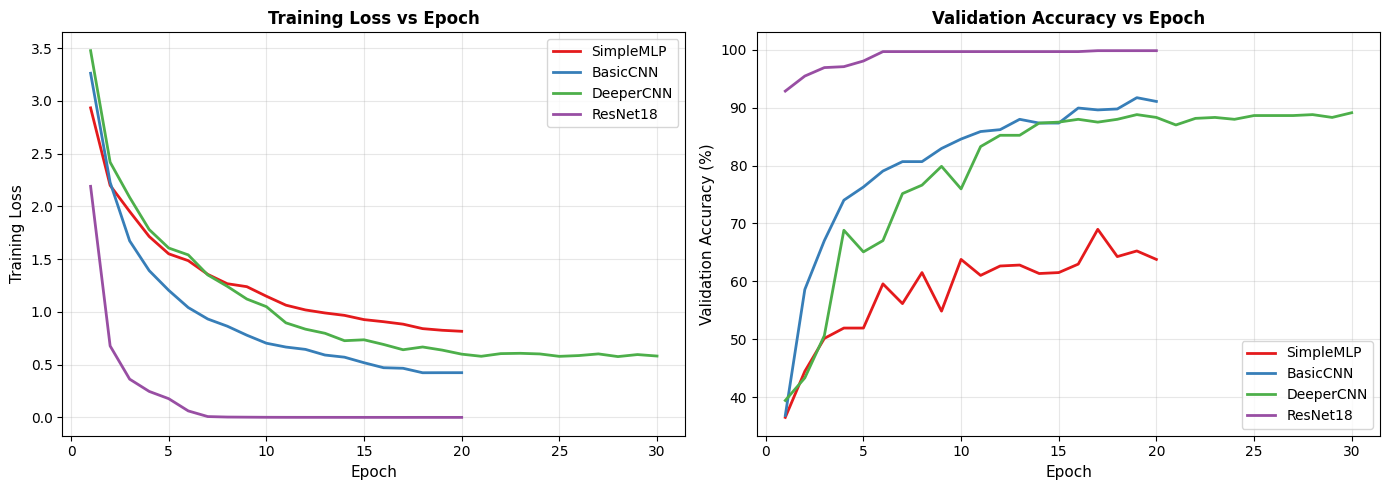

In [19]:
def plot_training_curves(all_histories, model_names):
    """Plot training loss and validation accuracy curves for all models."""

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

    # --- Training Loss ---
    ax1 = axes[0]
    for idx, name in enumerate(model_names):
        if name in all_histories:
            history = all_histories[name]
            epochs = range(1, len(history['train_loss']) + 1)
            ax1.plot(epochs, history['train_loss'],
                     label=name, color=colors[idx], linewidth=2)

    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Training Loss', fontsize=11)
    ax1.set_title('Training Loss vs Epoch', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # --- Validation Accuracy ---
    ax2 = axes[1]
    for idx, name in enumerate(model_names):
        if name in all_histories:
            history = all_histories[name]
            epochs = range(1, len(history['val_accuracy']) + 1)
            ax2.plot(epochs, history['val_accuracy'],
                     label=name, color=colors[idx], linewidth=2)

    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Validation Accuracy (%)', fontsize=11)
    ax2.set_title('Validation Accuracy vs Epoch', fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()


model_order = ['SimpleMLP', 'BasicCNN', 'DeeperCNN', 'ResNet18']

plot_training_curves(all_histories, model_order)

## Test Accuracy Comparison (Bar Chart)

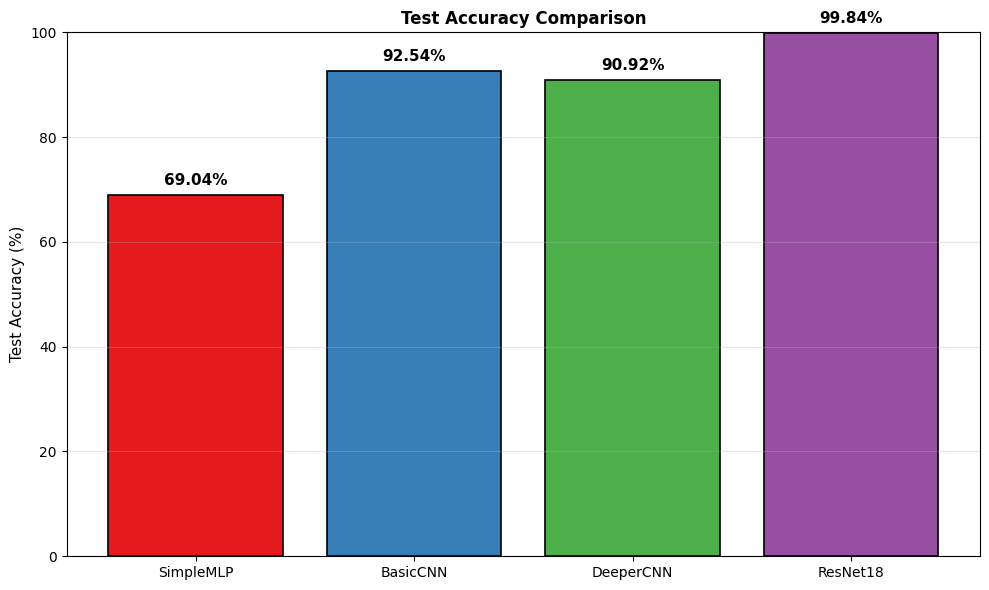

In [20]:
def plot_accuracy_comparison(all_results, model_names):
    """Bar chart comparing test accuracy across models."""

    accuracies = [all_results[name]['overall_accuracy'] for name in model_names]
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.2)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.annotate(f'{acc:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('accuracy_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_accuracy_comparison(all_results, model_order)

## Per-Class Accuracy Heatmap

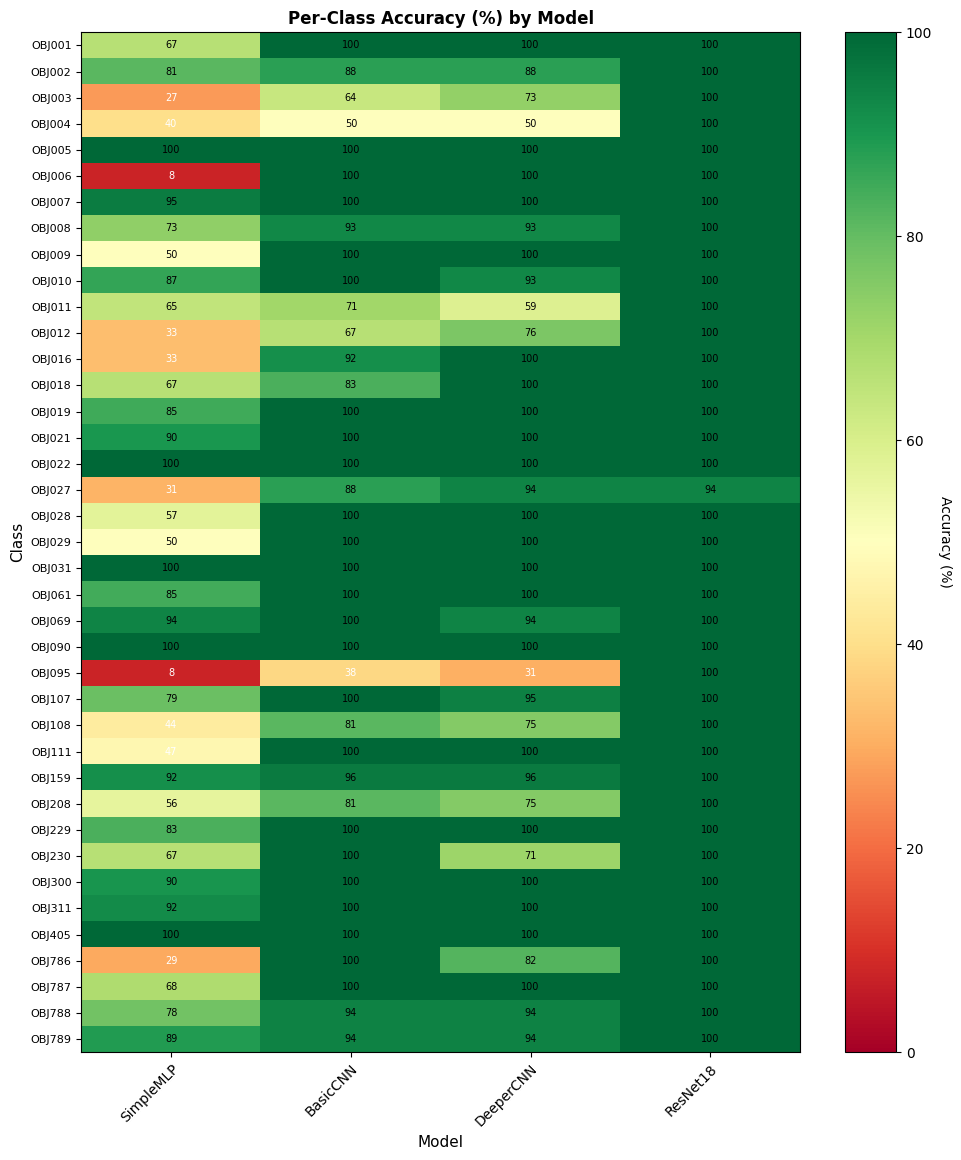

In [21]:
def plot_per_class_accuracy_heatmap(all_results, model_names, class_names):
    """Heatmap showing per-class accuracy for all models."""

    # Build matrix: rows = classes, columns = models
    matrix = np.zeros((len(class_names), len(model_names)))

    for col_idx, model_name in enumerate(model_names):
        for row_idx in range(len(class_names)):
            matrix[row_idx, col_idx] = all_results[model_name]['per_class_accuracy'][row_idx]

    # Adjust figure size based on number of classes
    fig_height = max(8, len(class_names) * 0.3)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

    # Labels
    ax.set_xticks(np.arange(len(model_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(model_names, fontsize=10)
    ax.set_yticklabels(class_names, fontsize=8)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(model_names)):
            value = matrix[i, j]
            text_color = 'white' if value < 50 else 'black'
            ax.text(j, i, f'{value:.0f}', ha='center', va='center',
                    color=text_color, fontsize=7)

    ax.set_title('Per-Class Accuracy (%) by Model', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Class', fontsize=11)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Accuracy (%)', rotation=-90, va="bottom", fontsize=10)

    plt.tight_layout()
    plt.savefig('per_class_accuracy_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_per_class_accuracy_heatmap(all_results, model_order, class_names)

## Training Time and Inference Time Comparison

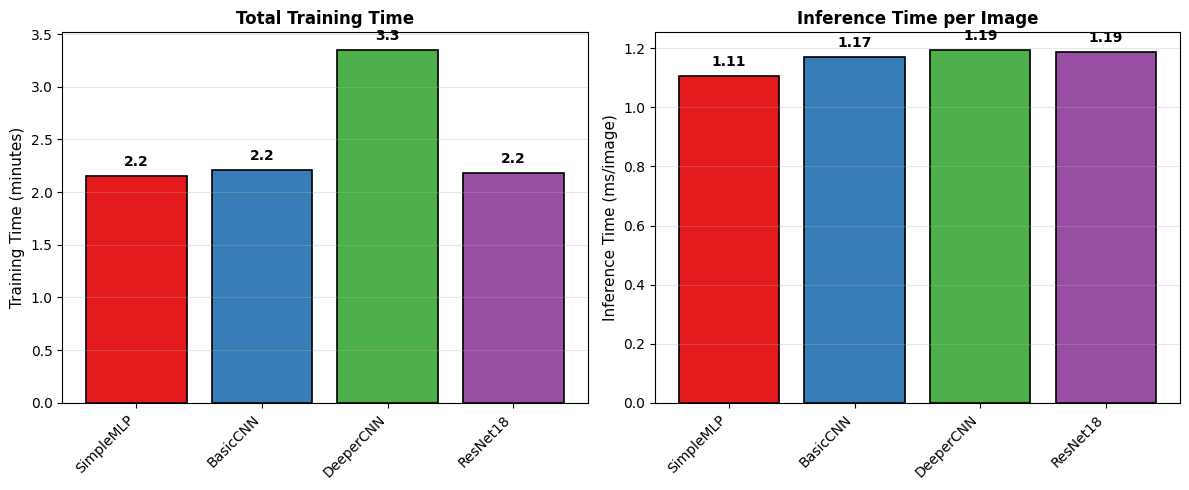

In [22]:
def plot_time_comparison(all_results, all_histories, model_names):
    """Bar charts for training time and inference time."""

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

    # --- Training Time ---
    ax1 = axes[0]
    train_times = [all_histories[name]['total_train_time'] / 60 for name in model_names]
    bars1 = ax1.bar(model_names, train_times, color=colors, edgecolor='black', linewidth=1.2)

    for bar, t in zip(bars1, train_times):
        height = bar.get_height()
        ax1.annotate(f'{t:.1f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax1.set_ylabel('Training Time (minutes)', fontsize=11)
    ax1.set_title('Total Training Time', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # --- Inference Time ---
    ax2 = axes[1]
    inf_times = [all_results[name]['inference_time_per_image_ms'] for name in model_names]
    bars2 = ax2.bar(model_names, inf_times, color=colors, edgecolor='black', linewidth=1.2)

    for bar, t in zip(bars2, inf_times):
        height = bar.get_height()
        ax2.annotate(f'{t:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2.set_ylabel('Inference Time (ms/image)', fontsize=11)
    ax2.set_title('Inference Time per Image', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig('time_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_time_comparison(all_results, all_histories, model_order)

## Confusion Matrices (All Models)

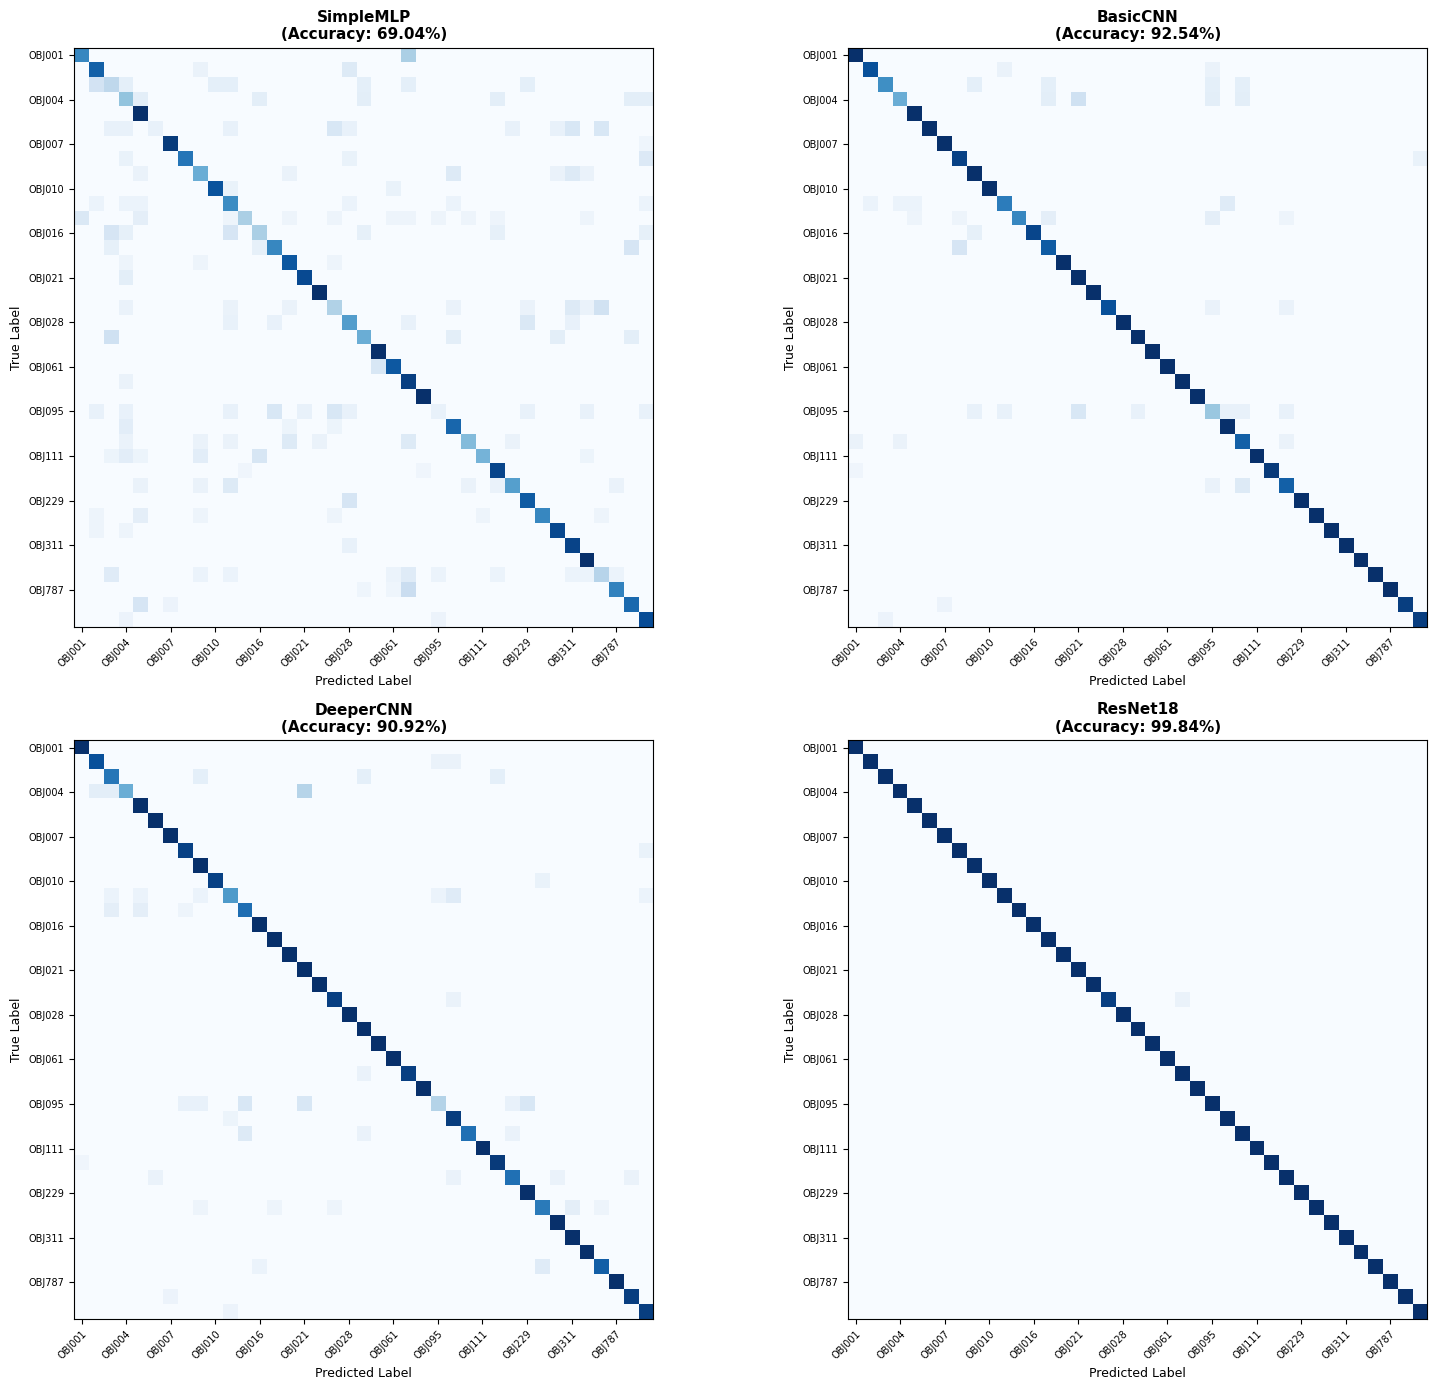

In [23]:
def plot_all_confusion_matrices(all_results, model_names, class_names):
    """Plot confusion matrices for all models in a grid."""
    from sklearn.metrics import confusion_matrix

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    for idx, name in enumerate(model_names):
        ax = axes[idx]
        results = all_results[name]

        cm = confusion_matrix(results['labels'], results['predictions'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')

        # For many classes, show fewer tick labels
        if len(class_names) > 20:
            tick_step = max(1, len(class_names) // 10)
            tick_positions = np.arange(0, len(class_names), tick_step)
            ax.set_xticks(tick_positions)
            ax.set_yticks(tick_positions)
            ax.set_xticklabels([class_names[i] for i in tick_positions], fontsize=7)
            ax.set_yticklabels([class_names[i] for i in tick_positions], fontsize=7)
        else:
            ax.set_xticks(np.arange(len(class_names)))
            ax.set_yticks(np.arange(len(class_names)))
            ax.set_xticklabels(class_names, fontsize=7)
            ax.set_yticklabels(class_names, fontsize=7)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax.set_title(f'{name}\n(Accuracy: {results["overall_accuracy"]:.2f}%)',
                     fontsize=11, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=9)
        ax.set_xlabel('Predicted Label', fontsize=9)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_all_confusion_matrices(all_results, model_order, class_names)

## Accuracy vs Parameters Scatter Plot

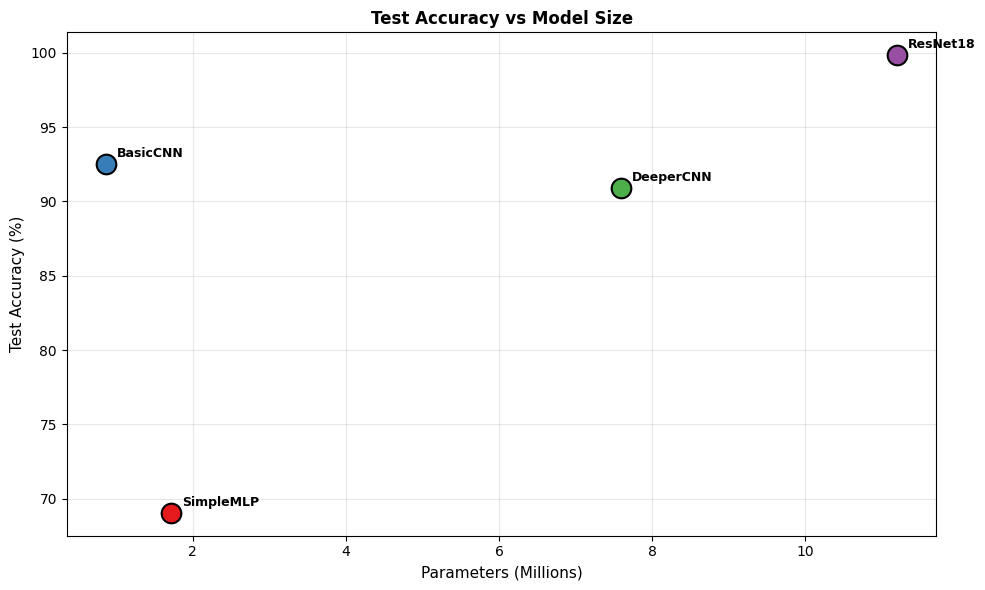

In [24]:
def plot_accuracy_vs_params(all_results, model_names):
    """Scatter plot: accuracy vs model size."""

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

    for idx, name in enumerate(model_names):
        params = all_results[name]['total_params'] / 1e6  # Millions
        acc = all_results[name]['overall_accuracy']

        ax.scatter(params, acc, s=200, c=colors[idx], edgecolor='black',
                   linewidth=1.5, label=name, zorder=3)

        ax.annotate(name, (params, acc), xytext=(8, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

    ax.set_xlabel('Parameters (Millions)', fontsize=11)
    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('Test Accuracy vs Model Size', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('accuracy_vs_params.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_accuracy_vs_params(all_results, model_order)

## Accuracy vs Training Time (Efficiency Plot)

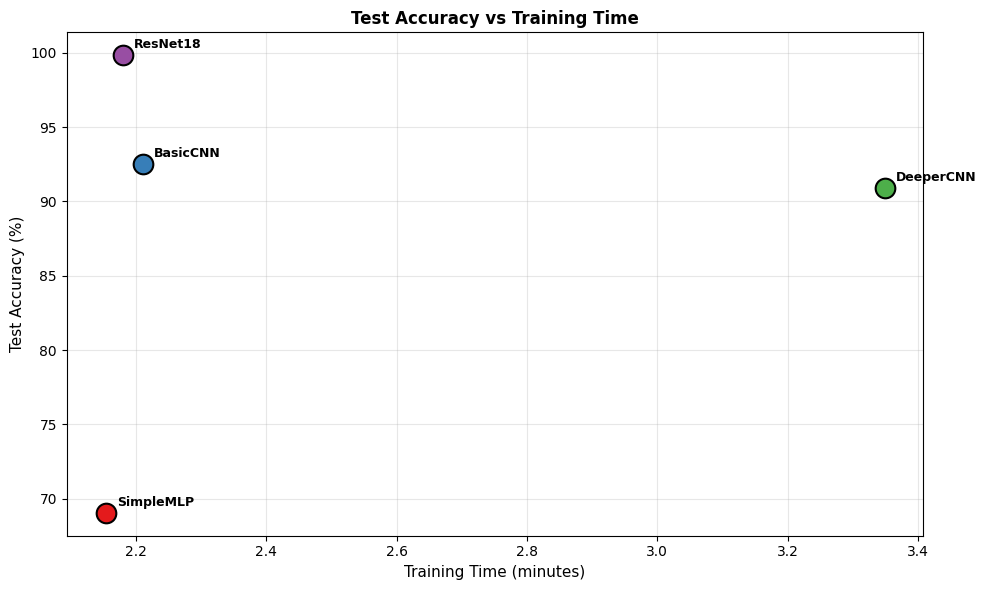

In [25]:
def plot_accuracy_vs_time(all_results, all_histories, model_names):
    """Scatter plot: accuracy vs training time."""

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

    for idx, name in enumerate(model_names):
        train_time = all_histories[name]['total_train_time'] / 60  # Minutes
        acc = all_results[name]['overall_accuracy']

        ax.scatter(train_time, acc, s=200, c=colors[idx], edgecolor='black',
                   linewidth=1.5, label=name, zorder=3)

        ax.annotate(name, (train_time, acc), xytext=(8, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

    ax.set_xlabel('Training Time (minutes)', fontsize=11)
    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('Test Accuracy vs Training Time', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('accuracy_vs_time.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_accuracy_vs_time(all_results, all_histories, model_order)
